# **Ejemplo 5: Barra FEM 1D - Formulación Global**

La barra mostrada en la figura tiene una longitud $L$, una sección transversal $A$ y un módulo de elasticidad $E$. La barra está sometida a una carga distribuida constante $q_o$ y a una carga puntal $P$.

In [180]:
from IPython.display import Image
Image(url='https://raw.githubusercontent.com/alejandromaranon/FEM/4cf38f29debcb9f013e90932674c8de662514d9e/Images/FEM_1D_barra_001.svg', width=300)

En este ejemplo se implementa el Método de Elementos Finitos (**formulación global**), para el cálculo de desplazamientos y esfuerzos en la barra.

## Forma fuerte (desplazamientos) del problema

Dados $A$, $E$ y $q_o$ en $[0,L]$ encontrar $u$ tal que:

$EA u_{,xx} + q_o = 0$ en $[0,L]$

$u=0$ en $x=0$

$u_{,x} = P/AE$ en $x=L$

Las soluciones exactas del desplazamiento y del esfuerzo de esta forma son las siguientes:

$u(x) = (P+q_oL)\frac{x}{AE}-\frac{q_ox^2}{2AE}$

$σ(x) = \frac{P}{A}+\frac{q_o}{A}(L-x)$

In [181]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta

**NOTA IMPORTANTE**:

En Python el primer indice (posición) de un arreglo (vector o matriz) es cero (0). A diferencia de Matlab, donde el primer indice es 1.


## Pre-procesamiento
Durante el preprocesamiento, se genera la malla para una geometría determinada y se especifican las propiedades de los materiales, las condiciones de frontera y las cargas prescritas.

In [182]:
# ----
# Parámetros de control del problema
# ----

# Geometría de la barra [SI]
L = 1.5             # Longitud en [m]
A = 0.01          # Area de la sección transversal [m^2]

# Propiedades mecánicas del material
E = 200E9         # Módulo de Elasticidad [Pa]

# Cargas en la barra
q0 = 100          # Carga distribuida [N/m]
P = 200           # Carga en el extremo [N]

# Discretización de elementos finitos
nel = 3           # Número de elementos
nnodos = nel + 1  # Número de nodos (nel + 1)

In [183]:
# ----
# Coordenadas (localización) de cada uno de los nodos
# (en este ejemplo se puede construir una discretizacion irregular
# utilizando la función beta)
# ----

# Esta función crea la malla irregular:
# "a" debe estar en el rango [0,1]
# Si nel es 1 o 2, la función crea elementos de la misma longitud.
# Si nel > 2, la función distribuye la longitud de elementos
# Si nel > 2 y a = 1.0, los elementos tienen la misma longitud

def discretizacion(divisiones=nnodos, inicio=0, final=L, a=0.1):
    x = np.linspace(0, 1, divisiones)
    return inicio + beta.cdf(x, 2.-a, 2.-a) * (final-inicio)

gcoord = discretizacion()

# print(gcoord)

In [184]:
# ----
# Arreglo de conectividad nodal de cada elemento
# (Topología de los elementos)
# ----

# Dado que en un problema 1D la numeración de los nodos
# es secuencial, se utiliza un arreglo bi-dimensional
# en el cual el primer indice indica el numero del elemento
# y el segundo o indice denota el número del nodo asociado con
# dicho elemento. La primera columna es el nodo 1 de la
# fomulación local y la segunda columna el nodo 2.

nodos = np.array([[i,i+1] for i in range(nel)], dtype=int)

# print(nodos)

In [185]:
# ----
# Tamaño de los elementos (longitud entre nodos)
# ----

he = np.zeros((nel, 1))

for num_ele in range(nel):
  # extrae los numeros globales de los nodos del elemento
  nodo1 = nodos[[num_ele],0]
  nodo2 = nodos[[num_ele],1]

  # extrae las coordenadas de los nodos
  x1 = gcoord[nodo1]
  x2 = gcoord[nodo2]

  # calcula la longitud del elemento
  he[num_ele] = (x2-x1)

# print(he)

In [186]:
# ----
# Condiciones de frontera
# (Desplazamientos conocidos)
# ----

# La primera columna de cf es el número del nodo y
# el segundo es el valor del desplazamiento en dicho nodo.

cf = np.array([[0, 0]])

# print(cf)

In [187]:
# ----
# Fuerzas nodales aplicadas
# ----

fn = np.array([[(nnodos-1), P]]).astype(object)
fn [:,0] = fn [:,0].astype(int)

# print(fn)

## Solución
Durante la solución, se calculan las matrices de elementos y se resuelven las ecuaciones.

In [188]:
# ----
# Construcción de la matríx de rígidez K
# ----

K = np.zeros((nnodos, nnodos))

for i in range(nnodos):
    # Calcula la matriz triangular superior y luego aplica simetría
    for j in range(i, nnodos):
        if i == j:
            if i == 0:
                K[i, j] = E*A/he[j,0]
            elif i == nnodos - 1:
                K[i, j] = E*A/he[j-1,0]
            else:
                K[i, j] = E*A*(1/he[j-1,0]+1/he[j,0])
        elif abs(i - j) == 1:
            K[i, j] = -E*A/he[j-1,0]
            K[j, i] = K[i, j] # Simetría de la matriz de rigidez

# print(K)

In [189]:
# ----
# Construcción del vector de fuerza F
# ----

F = np.zeros((nnodos, 1))

for i in range(nnodos):
  if (i == 0):
    F[i] = q0*(he[i,0])/2
  elif (i == nnodos - 1):
    F[i] = q0*(he[i-1,0])/2
  else:
    F[i] = q0*(he[i-1,0] + he[i,0])/2

# ----
# Se incluyen en F las fuerzas nodales aplicadas (fn)
# ----

for num_fn in range(fn.shape[0]):
  i = fn[num_fn,0]      # este es el número del nodo
  F[i] += fn[num_fn,1]   # se suma el valor de la fuerza en el nodo

# print(F)

In [190]:
# prompt: Stop execution

# import sys
# sys.exit()


In [191]:
# ----
# Aplica las restricciones (desplazamientos conocidos)
# modificando K y F
# ----

# Se utiliza una copia de K para incluir las condiciones de frontera cf
Kcf = np.copy(K)

for num_cf in range(cf.shape[0]):
  i = cf[num_cf,0]      # este es el número del nodo
  F[i] = cf[num_cf,1]   # este es el valor del desplazamiento

  for j in range(nnodos):
    if i==j:
      Kcf[i,j] = 1
    else:
      Kcf[i,j] = 0

# print(Kcf,F)

In [192]:
# ----
# Cálculo de desplazamientos nodales
# ----

u = np.linalg.solve(Kcf,F)

# print(u)

In [193]:
# ----
# Calculo de reacciones nodales
# ----

Rn = K@u

# print(Rn)

In [194]:
# ----
# Calculo de esfuerzos en los elementos
# ----

esfuerzo =[]

for num_ele in range(nel):
  # extrae los numeros globales de los nodos del elemento
  nodo1 = nodos[[num_ele],0]
  nodo2 = nodos[[num_ele],1]

  # calcula la longitud del elemento
  esfuerzo.append(E*(-u[nodo1]+u[nodo2])/he[num_ele])

#print(esfuerzo)

## Post-procesamiento
Esta etapa se utiliza para visualizar las soluciones y ver imágenes gráficas de los desplazamientos, esfuerzos, deformaciones, etc.

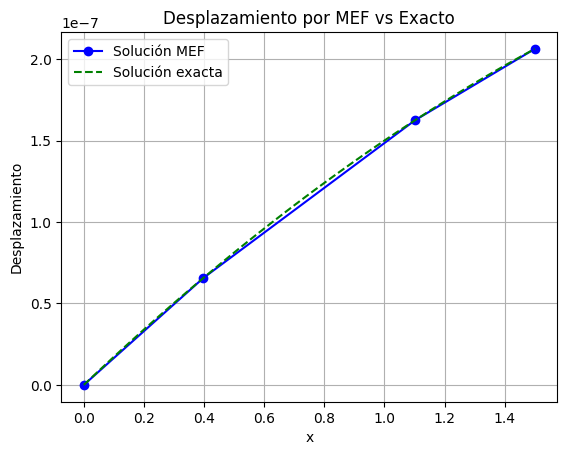

In [195]:
# ----
# Grafica de desplazamientos
# ----

# Deplazamientos del MEF
plt.plot(gcoord, u, 'b', marker = 'o', label='Solución MEF')
plt.xlabel('x')
plt.ylabel('Desplazamiento')
plt.title('Desplazamiento por MEF vs Exacto')

# Desplazamientos exactos
x = np.linspace(0,L)
plt.plot(x, ((P+q0*L)*x-0.5*(q0*x**2))/(A*E), 'g--', label='Solución exacta')
plt.legend(loc='best')
plt.grid(True)

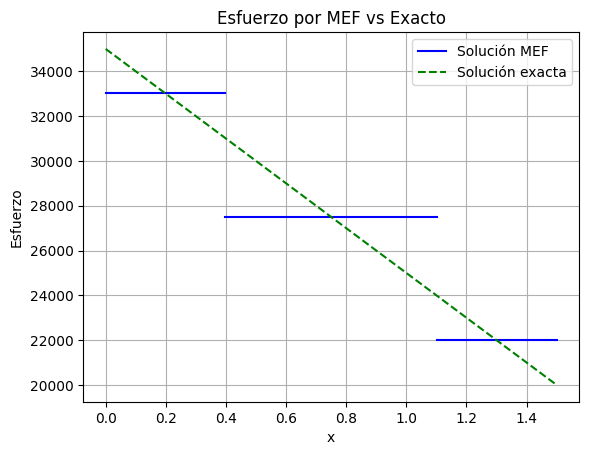

In [196]:
# ----
# Grafica de esfuerzos
# ----

# Esfuerzos del MEF
for num_ele in range(nel):
  # extrae los numeros globales de los nodos del elemento
  nodo1 = nodos[[num_ele],0]
  nodo2 = nodos[[num_ele],1]

  # extrae las coordenadas de los nodos
  x1 = gcoord[nodo1]
  x2 = gcoord[nodo2]

  plt.plot([x1,x2], [esfuerzo[num_ele][0], esfuerzo[num_ele][0]],'b')

# Esta línea es para que aparezca la etiqueta 'Solución MEF'
plt.plot([],[], 'b', label = 'Solución MEF')

# Esfuerzos de la solución exacta
plt.plot(x, (q0*(L-x)+P)/A, 'g--', label='Solución exacta')
plt.legend(loc='best')

plt.xlabel('x')
plt.ylabel('Esfuerzo')
plt.title('Esfuerzo por MEF vs Exacto')
plt.grid(True)


In [197]:
# ----
# Reporte de parámetros para análisis de convergencia
# ----

# Esfuerzo máximo del MEF
print(np.max(np.absolute(esfuerzo)))

33010.76677239611


## FIN